In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


In [6]:

import importlib
import utils.data_processing as data_processing
importlib.reload(data_processing)
from utils.data_processing import get_dataloaders, set_seed, save_output, get_df

In [7]:

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [ ]:
df = get_df()

In [9]:

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = ['c4', 'c5', 'c6', 'c7', 'c8', 'c9']


X_seq = df[seq_features]
X_static = df[static_features]

y = df[target]
PAD_IDX = -100
y = df[['c4','c5','c6','c7','c8','c9']].copy() 
y = y.fillna(PAD_IDX)



convert to tensor for pytorch

In [10]:
TIME_STEPS = 4
SEQ_LEN = len(seq_features) // TIME_STEPS
BATCH_SIZE=32
train_loader, test_loader, test_loader_h1, test_loader_h6 = get_dataloaders(X_seq, X_static, y)

# Model

In [11]:
from utils.models import (
    Seq2SeqGRU
)

# train / eval

In [12]:
def stepwise_accuracy(logits, labels, pad_idx=-100):
    preds = logits.argmax(dim=-1)  # [B, L]
    L = labels.size(1)
    accs = []

    for t in range(L):
        mask = labels[:, t] != pad_idx
        if mask.sum() > 0:
            correct = (preds[:, t][mask] == labels[:, t][mask]).sum().item()
            accs.append(correct / mask.sum().item())
        else:
            accs.append(float('nan')) 
    return accs

In [13]:
def train(model, train_loader, criterion, optimizer, device, pad_idx=-100):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logits = model(seq_inputs, static_inputs, targets=labels, teacher_forcing_ratio=1.0)
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=-1)
        mask = labels != pad_idx
        correct += (preds[mask] == labels[mask]).sum().item()
        total += mask.sum().item()
        train_loss += loss.item() * seq_inputs.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return accuracy, avg_loss


def test(model, test_loader, criterion, device, pad_idx=-100):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    step_acc_sum = None
    n_batches = 0

    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            logits = model(seq_inputs, static_inputs, teacher_forcing_ratio=0.0)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            preds = logits.argmax(dim=-1)
            mask = labels != pad_idx
            correct += (preds[mask] == labels[mask]).sum().item()
            total += mask.sum().item()
            total_loss += loss.item() * seq_inputs.size(0)

            # step-wise accuracy for this batch
            batch_step_accs = stepwise_accuracy(logits, labels, pad_idx)
            if step_acc_sum is None:
                step_acc_sum = [0.0] * len(batch_step_accs)
            for i, acc in enumerate(batch_step_accs):
                if not (acc != acc):  # skip NaNs
                    step_acc_sum[i] += acc
            n_batches += 1

    accuracy = correct / total
    avg_loss = total_loss / len(test_loader.dataset)
    step_accs = [a / n_batches for a in step_acc_sum]
    return accuracy, avg_loss, step_accs

In [14]:
def train_and_evaluate(model, train_loader, test_loader, test_loader_h1, test_loader_h6,
                       criterion, optimizer, device, epochs, pad_idx=-100):
    train_loss_prog, train_acc_prog = [], []
    test_loss_prog, test_acc_prog = [], []
    test_acc_h1_prog, test_loss_h1_prog, test_step_h1_prog = [], [], []
    test_acc_h6_prog, test_loss_h6_prog, test_step_h6_prog = [], [], []

    best_loss = float('inf')
    patience, epochs_no_improve = 5, 0
    final_epoch = epochs

    for epoch in range(epochs):
        train_acc, train_loss = train(model, train_loader, criterion, optimizer, device, pad_idx)
        test_acc, test_loss, _ = test(model, test_loader, criterion, device, pad_idx)
        test_acc_h1, test_loss_h1, step_acc_h1 = test(model, test_loader_h1, criterion, device, pad_idx)
        test_acc_h6, test_loss_h6, step_acc_h6 = test(model, test_loader_h6, criterion, device, pad_idx)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: overall {test_acc:.3f}, H1 {test_acc_h1:.3f}, H6 {test_acc_h6:.3f}")

        # log
        train_acc_prog.append(train_acc); train_loss_prog.append(train_loss)
        test_acc_prog.append(test_acc); test_loss_prog.append(test_loss)
        test_acc_h1_prog.append(test_acc_h1); test_loss_h1_prog.append(test_loss_h1); test_step_h1_prog.append(step_acc_h1)
        test_acc_h6_prog.append(test_acc_h6); test_loss_h6_prog.append(test_loss_h6); test_step_h6_prog.append(step_acc_h6)

        # early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve > patience:
            print(f"Early stopping at epoch {epoch+1}, best loss {best_loss:.4f}")
            final_epoch = epoch+1
            break

    return {
        "train_acc": train_acc_prog,
        "train_loss": train_loss_prog,
        "test_acc": test_acc_prog,
        "test_loss": test_loss_prog,
        "h1_acc": test_acc_h1_prog,
        "h1_loss": test_loss_h1_prog,
        "h1_step_acc": test_step_h1_prog,
        "h6_acc": test_acc_h6_prog,
        "h6_loss": test_loss_h6_prog,
        "h6_step_acc": test_step_h6_prog,
        "final_epoch": final_epoch
    }

# running experiment

In [15]:
model_dict = {
    "Seq2SeqGRU": Seq2SeqGRU(SEQ_LEN).to(device),
}

In [16]:
epochs = 100
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(
        model,
        train_loader,
        test_loader,
        test_loader_h1,
        test_loader_h6,
        criterion,
        optimizer,
        device,
        epochs=epochs
    )

    model_dict[model_name] = {
        "model": model,
        **history
    }



Training model: Seq2SeqGRU
Epoch 1: overall 0.769, H1 0.815, H6 0.761
Early stopping at epoch 7, best loss 0.5123


In [17]:
save_output(model_dict, "output_later_trials")

Saved model results to output_later_trials.json


# plotting

In [18]:
from utils.plotting import plot_h6_stepwise

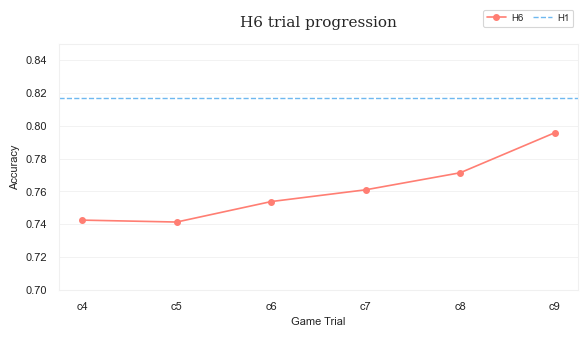

In [19]:
plot_h6_stepwise(history, model_name="Seq2SeqGRU")